In [1]:
import pandas as pd
import numpy as np
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Run the stored data from the Data_Preparation.ipynb
%run ..//Data_Preparation.ipynb

Data types in 'indu' dataframe:
Time       datetime64[ns]
indu_Q1           float64
indu_Q2           float64
indu_Q3           float64
indu_Q4           float64
indu_Q5           float64
indu_Q7           float64
dtype: object

Data types in 'cons' dataframe:
Time        datetime64[ns]
cons_Q1            float64
cons_Q2            float64
cons_Q3            float64
cons_Q4            float64
cons_Q5            float64
cons_Q6            float64
cons_Q7            float64
cons_Q8            float64
cons_Q9            float64
cons_Q10           float64
cons_Q11           float64
cons_Q12           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object
indu_Q1           float64
indu_Q2           float64
indu_Q3           float64
indu_Q4           float64
indu_Q5           float64
indu_Q7           float64
Time       datetime64[ns]
dtype: object
cons_Q1            float64
cons_Q2            float64
cons_Q3            float64
con

In [3]:
#Using the period 1990-2015 for training and 2016-2020 for testing
indu_train = indu[(indu['Time'] >= '1990-01-01') & (indu['Time'] < '2016-01-01')]
cons_train = cons[(cons['Time'] >= '1990-01-01') & (cons['Time'] < '2016-01-01')]
gdp_train = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2016-01-01')]

indu_test = indu[(indu['Time'] >= '2016-01-01') & (indu['Time'] < '2020-01-01')]
cons_test = cons[(cons['Time'] >= '2016-01-01') & (cons['Time'] < '2020-01-01')]
gdp_test = gdp[(gdp['Time'] >= '2016-01-01') & (gdp['Time'] < '2020-01-01')]

#Since gdp is not stationary, we will take the first difference
gdp_train['Value_diff'] = gdp_train['Value'].diff().fillna(0)

#Combine the explanatory data into one dataframe
exog_train = pd.merge(indu_train, cons_train, on='Time')
exog_train = exog_train.drop(['Time'], axis=1)

exog_test = pd.merge(indu_test, cons_test, on='Time')
exog_test = exog_test.drop(['Time'], axis=1)

#Extract the target variable
endog_train = gdp_train['Value_diff']
endog_test = gdp_test['Value']

# Define hyperparameters grid for grid search
param_grid = {
    'max_depth': [4, 5, 6],
    'min_child_weight': [5, 10, 15],
    'gamma': [0.5, 1, 1.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

#Setting the seed for reproducibility
seed = 42

# Instantiating the XGBoost Regressor model
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=seed)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fitting the model
grid_search.fit(exog_train, endog_train)

# Getting the best parameters
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

# Get the best estimator
best_xgb_reg = grid_search.best_estimator_

# Forecasting the GDP
y_pred = best_xgb_reg.predict(exog_test)

# Reversing the first difference
y_pred_norm = np.cumsum(y_pred) + gdp_test['Value'].iloc[0]

# Calculating the RMSE
rmse_value = rmse(endog_test, y_pred_norm)
#Calculating the MAPE
mape_value = mean_absolute_percentage_error(endog_test, y_pred_norm)*100 #Multiplying by 100 to get the percentage

print("The RMSE of the model is:", rmse_value)
print("The MAPE of the model is:", mape_value)

#The RMSE of the model is: 17. This is pretty good, but the model is not able to capture the seasonality of the data.
#The MAPE of the model is: 2,4%. This is pretty good.

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8}
The RMSE of the model is: 31.529688046258077
The MAPE of the model is: 4.76521795397356


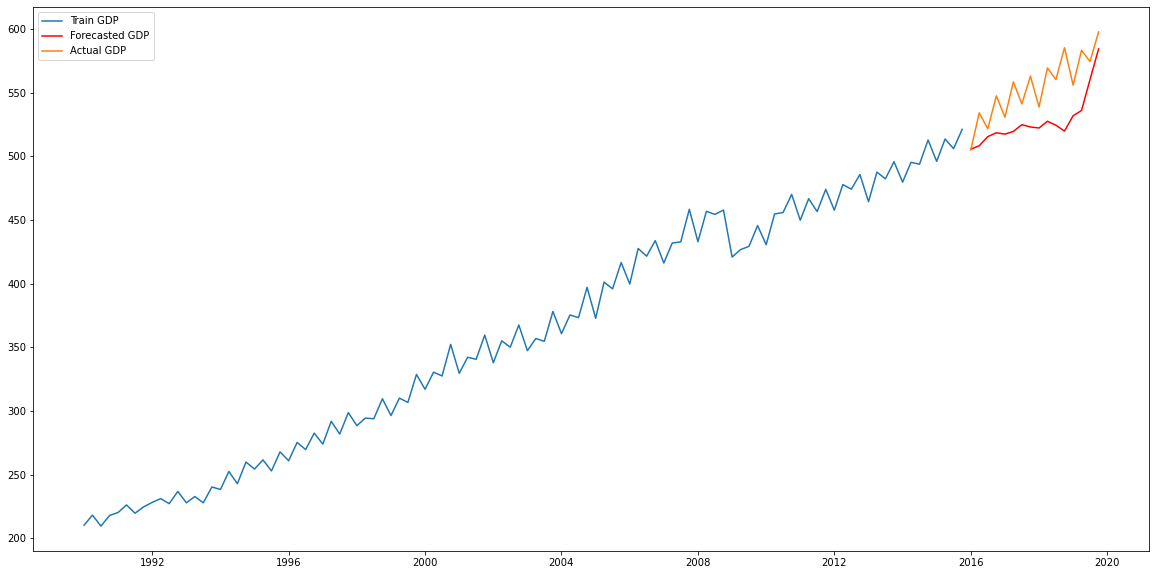

In [4]:
#Plotting the results against the actual values
plt.figure(figsize=(20,10))
plt.plot(gdp_train['Time'].to_numpy(), gdp_train['Value'].to_numpy(), label='Train GDP')
plt.plot(gdp_test['Time'].to_numpy(), y_pred_norm, label='Forecasted GDP', color='red')
plt.plot(gdp_test['Time'].to_numpy(), gdp_test['Value'].to_numpy(), label='Actual GDP')
plt.legend(loc='upper left')
plt.show()

In [5]:
import os
import json

#Define the evaluation metric name for this model
metric_name = "Multi_All_Pre_GB"

# Create a dictionary with the MAPE value

# Get the current directory
current_dir = os.getcwd()

# Navigate to the directory where mape_values.json is located
json_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'mape_values.json'))

# Check if the file exists and is not empty
if os.path.exists(json_dir) and os.path.getsize(json_dir) > 0:
    # Load the .json file that stores the MAPE results
    with open(json_dir, 'r') as file:
        data = json.load(file)
else:
    data = {}

# Add the MAPE value to the dictionary with a corresponding key
data[metric_name] = mape_value

# Write the MAPE value to the .json file
with open(json_dir, 'w') as file:
    json.dump(data, file, indent=4)

# Create a dictionary with the RMSE value

# Navigate to the directory where rsme_values.json is located
json_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'rsme_values.json'))

# Check if the file exists and is not empty
if os.path.exists(json_dir) and os.path.getsize(json_dir) > 0:
    # Load the .json file that stores the RMSE results
    with open(json_dir, 'r') as file:
        data = json.load(file)
else:
    data = {}

# Add the RMSE value to the dictionary with a corresponding key
data[metric_name] = rmse_value

# Write the RMSE value to the .json file
with open(json_dir, 'w') as file:
    json.dump(data, file, indent=4)